# Setup

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from transformer_lens import HookedTransformer
import random
import sys
import os
import collections
import operator

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)
from pyfunctions.general import compare_same
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.cdt_from_source_nodes import *
from pyfunctions.toy_model import *
import seaborn as sns
import matplotlib.pyplot as plt

import torch
Result = collections.namedtuple('Result', ('ablation_set', 'score'))


/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
# from mi_utils_public import *
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
model = HookedTransformer.from_pretrained('attn-only-4l',
                                         fold_ln=False)

"""Toggle whether to explicitly calculate and expose the result for each attention head.
Useful for interpretability but can easily burn through GPU memory.
        """
model.cfg.use_attn_result = False # Not actually needed because we have methods for accessing the activation cache anyway.
# note from the mi_utils guys: "because running subprocess breaks things"
# %env TOKENIZERS_PARALLELISM=true



/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- 

Loaded pretrained model attn-only-4l into HookedTransformer


In [5]:

from im_utils.prompts import Prompt, docstring_ind_prompt_gen

batch_size = 100

docstring_ind_prompt_kwargs = dict(
    n_matching_args=3,
    n_def_prefix_args=2,
    n_def_suffix_args=1,
    n_doc_prefix_args=0,
    met_desc_len=3,
    arg_desc_len=2
)
prompts = [docstring_ind_prompt_gen("rest", **docstring_ind_prompt_kwargs) for _ in range(batch_size)]

In [6]:
'''
for prompt_idx in range(10):
    example_prompt = prompts[prompt_idx].clean_prompt
    tokens = model.to_str_tokens(example_prompt)

    example_answer = tokens[pos_labels.index("C_def")]
    # print(example_prompt)
    print(example_answer)
    # transformer_lens.utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)
    # print('#####################')
    print(model.to_string(model.generate(example_prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1]))
    print(example_answer == model.to_string(model.generate(example_prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1]))
    print('#####################')
'''    

NameError: name 'pos_labels' is not defined

In [8]:
tokens = model.to_str_tokens(prompts[0].clean_prompt)


In [9]:
pos_labels = model.to_str_tokens(prompts[0].clean_prompt)
pos_labels[ 0] = "BOS"
pos_labels[ 1] = "⏎"
pos_labels[ 2] = "def"
pos_labels[ 3] = "rand0"
pos_labels[ 4] = "("
pos_labels[ 5] = "self"
pos_labels[ 6] = ",_0"
pos_labels[ 7] = "rand1"
pos_labels[ 8] = ",_1"
pos_labels[ 9] = "rand2"
pos_labels[10] = ",_2"
pos_labels[11] = "A_def"
pos_labels[12] = ",_A"
pos_labels[13] = "B_def"
pos_labels[14] = ",_B"
pos_labels[15] = "C_def"
pos_labels[16] = ",_C"
pos_labels[17] = "rand3"
pos_labels[18] = "):"
pos_labels[19] = "⏎···_0"
pos_labels[20] = '"""'
pos_labels[21] = "rand4"
pos_labels[22] = "rand5"
pos_labels[23] = "rand6"
pos_labels[24] = "⏎⏎···_1"
pos_labels[25] = "·:_0"
pos_labels[26] = "param_1"
pos_labels[27] = "A_doc"
pos_labels[28] = ":_1"
pos_labels[29] = "rand7"
pos_labels[30] = "rand8"
pos_labels[31] = "⏎···_2"
pos_labels[32] = "·:_1"
pos_labels[33] = "param_2"
pos_labels[34] = "B_doc"
pos_labels[35] = ":_2"
pos_labels[36] = "rand9"
pos_labels[37] = "rand10"
pos_labels[38] = "⏎···_3"
pos_labels[39] = "·:_2"
pos_labels[40] = "param_3"

In [10]:
# Get a "better" dataset, i.e, ones where the model answers the correct answer, preferably by a wide margin.
# the toy model actually isn't very good at the docstring task, only getting it right like 50-75% of the time.
# We obviously can't investigate the question of how the model does the docstring task if it's not actually "doing" it.
good_prompts = []
for prompt in prompts:
    clean_prompt = prompt.clean_prompt
    tokens = model.to_str_tokens(clean_prompt)
    # it's perhaps better to check if the model's prediction logit is highest by a certain threshold.
    correct_answer = tokens[pos_labels.index("C_def")]
    model_prediction = model.to_string(model.generate(clean_prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1])
    if model_prediction == correct_answer:
        good_prompts.append(prompt)
prompts = good_prompts

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
len(prompts)

64

In [12]:
num_layers = len(model.blocks)
seq_len = len(pos_labels)
num_attention_heads = model.cfg.n_heads

In [13]:
# this thing assumes the input is a list of sequences, the sequences are a list of tokens
# if you pass in only a single list, you should wrap it in a [] 
def compute_logits_decomposition_scores(texts, out_decomps):
    if not isinstance(texts, list):
        texts = [texts] # so that the batching works out
    relevances = np.zeros((num_layers, seq_len, num_attention_heads))
     # NOT to_tokens(text)
    batch_size = len(texts)
    results = []

    for layer_idx in range(num_layers):
        for seq_pos in range(seq_len):
            for head_idx in range(num_attention_heads):
                score = 0
                decomp = out_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]
                for i in range(batch_size):
                    tokens = model.to_str_tokens(texts[i])
                    correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
                    rel_correct_logit = decomp.rel[i, -1, correct_logit_idx]
                    incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                                     pos_labels.index("rand0"),
                                     pos_labels.index("rand1"),
                                     pos_labels.index("rand2"),
                                     pos_labels.index("rand3"),
                                     pos_labels.index("rand4"),
                                     pos_labels.index("rand5"),
                                     pos_labels.index("rand6"),
                                     pos_labels.index("rand7"),
                                     pos_labels.index("rand8"),
                                     pos_labels.index("rand9"),
                                     pos_labels.index("rand10"),
                                     ]
                    incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
                    rel_incorrect_logits = decomp.rel[i, -1, incorrect_logit_idxs]
                    score += np.min(rel_correct_logit - rel_incorrect_logits)
                    relevances[layer_idx, seq_pos, head_idx] = score
                score /= batch_size
                results.append(Result(decomp.ablation_set, score))
    # sums_per_layer = np.sum(relevances, axis=(1, 2))
    # sums_per_layer[sums_per_layer == 0] = -1e-8
    # normalized_relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))
    results.sort(key=operator.attrgetter('score'), reverse=True)
    return results, relevances

In [14]:
def calculate_target_decomposition_scores(target_decomps, normalized=False):
    relevances = np.zeros((num_layers, seq_len, num_attention_heads))
    results = []
    for layer_idx in range(num_layers):
        for seq_pos in range(seq_len):
            for head_idx in range(num_attention_heads):
                score = 0
                target_decomp = target_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]

                for i in range(len(target_decomp.target_nodes)):
                    rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
                    irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
                    target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
                    score += (target_node_score)
                if target_decomp.ablation_set[0] in target_nodes:
                    score = 0
                relevances[layer_idx, seq_pos, head_idx] = score
                if not normalized:
                    results.append(Result(target_decomp.ablation_set, relevances[layer_idx, seq_pos, head_idx]))
    if normalized:
        sums_per_layer = np.sum(relevances, axis=(1, 2))
        sums_per_layer[sums_per_layer == 0] = -1e-8
        relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))

        for layer_idx in range(num_layers):
            for seq_pos in range(seq_len):
                for head_idx in range(num_attention_heads):
                    target_decomp = target_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]
                    results.append(Result(target_decomp.ablation_set, relevances[layer_idx, seq_pos, head_idx]))
    
    results.sort(key=operator.attrgetter('score'), reverse=True)
    return results, relevances

# Datatype investigation

In [ ]:
print(model)

In [22]:
# dir(prompts[0])
'''
'clean_prompt',
 'correct_answers',
 'corrupt_prompt',
 'print_all_corrupt',
 'print_all_corrupt_tokenized',
 'print_clean',
 'print_clean_tokenized',
 'print_corrupt',
 'print_corrupt_tokenized',
 'print_tokenized',
 'wrong_answers'
'''

print(prompts[0].clean_prompt)
# 'random_doc', 'random_def', 'random_answer', 'random_def_doc', 'random_answer_doc', 'random_random', 'vary_length_doc_desc', 'vary_length_doc_desc_random_doc'
# print(prompts[0].corrupt_prompt.keys())
# type(prompts[0])
# These are actually decently well explained in the original LessWrong post, I just didn't see it at first.
print(prompts[0].corrupt_prompt['random_doc'])
print(prompts[0].corrupt_prompt['random_def_doc'])
print(prompts[0].corrupt_prompt['random_answer_doc'])
print(prompts[0].corrupt_prompt['random_random'])
print(prompts[0].corrupt_prompt['vary_length_doc_desc'])
print(prompts[0].corrupt_prompt['vary_length_doc_desc_random_doc'])



def msg(self, description, status, call):
    """choice minute sort

    :param description: drug machine
    :param status: ground register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, state, server, call):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, description, status, option):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, filename, valid, host):
    """choice minute sort

    :param name: drug machine
    :param index: ground register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param description: drug
    :param status: ground machine register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param state: drug
    :param server: grou

# Correctness tests for implementation of CD-T

In [162]:
logits, cache = model.run_with_cache(prompts[0].clean_prompt)
tokens = model.to_tokens(prompts[0].clean_prompt).to(device)
# logits, cache = model.run_with_cache(tokens)
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

hook_embed                     (1, 35, 512)
hook_pos_embed                 (1, 35, 512)
blocks.0.hook_resid_pre        (1, 35, 512)
blocks.0.ln1.hook_scale        (1, 35, 1)
blocks.0.ln1.hook_normalized   (1, 35, 512)
blocks.0.attn.hook_q           (1, 35, 8, 64)
blocks.0.attn.hook_k           (1, 35, 8, 64)
blocks.0.attn.hook_v           (1, 35, 8, 64)
blocks.0.attn.hook_attn_scores (1, 8, 35, 35)
blocks.0.attn.hook_pattern     (1, 8, 35, 35)
blocks.0.attn.hook_z           (1, 35, 8, 64)
blocks.0.hook_attn_out         (1, 35, 512)
blocks.0.hook_resid_post       (1, 35, 512)
ln_final.hook_scale            (1, 35, 1)
ln_final.hook_normalized       (1, 35, 512)


In [158]:
compare_same(cache['blocks.1.hook_resid_pre'], cache['blocks.0.hook_resid_post'])

100.00% of the values are equal


1.0

In [25]:
encoding = model.tokenizer.encode_plus(prompts[0].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 # prepend_bos=True, # currently dealing with this: make sure BOS prepend matches because currently the sequence lengths are off-by-one
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask

# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [175]:
in_0 = cache['blocks.0.hook_resid_pre']
compare_same(cache['hook_embed'] + cache['hook_pos_embed'], cache['blocks.0.hook_resid_pre'])

# Ensure that the encodings are the same (they won't be if you set prepend_bos=True for one and not the other!)
# print(tokens)
# print(encoding.input_ids)

# Note that model.embed alone isn't the same thing as what we might normally call "the embedding"!
embedding_output = model.embed(encoding_idxs) + model.pos_embed(encoding_idxs)
compare_same(in_0, embedding_output, atol=1e-8, rtol=1e-6)

100.00% of the values are equal
100.00% of the values are equal


1.0

In [136]:

att_probs = prop_toy_model_4l_layer(torch.zeros_like(in_0), embedding_output, extended_attention_mask, None, 
                  {}, [], 0, None,
                  model.blocks[0], device, att_probs = None, set_irrel_to_mean=False, target_decomp_method="residual")
compare_same(att_probs, cache['blocks.0.attn.hook_pattern'])
# print(type(att_probs))

100.00% of the values are equal


1.0

In [142]:
# now check correctness of prop implementation
rel, irrel, _, _ = prop_toy_model_4l_layer(torch.zeros_like(in_0), embedding_output, extended_attention_mask, None, 
                  {}, [], 0, None,
                  model.blocks[0], device, att_probs = None, set_irrel_to_mean=False, target_decomp_method="residual")
output_layer_0 = rel + irrel

In [177]:
compare_same(output_layer_0, cache['blocks.1.hook_resid_pre'], atol=1e-4)
# print(type(desired_output_layer_0))
# compare_same(output_layer_0, cache['blocks.1.hook_resid_pre'], atol=1e-6, rtol=1e-5) # numerical error accumulation is significant for this model compared to gpt-2, wonder why?


99.99% of the values are equal


0.9999441964285715

In [167]:
out_a_ln = prop_toy_model_4l(encoding_idxs,
            extended_attention_mask,
            model,
            [(Node(0, 0, 0),)],
            [],
            device,
            mean_acts = None,
            att_list = None,
            set_irrel_to_mean=False
)

In [168]:
compare_same(cache['ln_final.hook_normalized'], out_a_ln)

99.66% of the values are equal


0.9965959821428572

In [165]:
out_decomps, _, _, _ = prop_toy_model_4l(encoding_idxs,
            extended_attention_mask,
            model,
            [(Node(0, 0, 0),)],
            [],
            device,
            mean_acts = None,
            att_list = None,
            set_irrel_to_mean=False
)
output_total = out_decomps[0].rel + out_decomps[0].irrel

In [156]:
print(logits.shape)

torch.Size([1, 35, 48262])


In [173]:
compare_same(output_total, logits, atol=1) # error accumulated approaches 1e-4 in absolute value.


100.00% of the values are equal


0.999997039966374

In [180]:
print(prompts[0].clean_prompt)


def user(self, node, ret, order, version, read, settings):
    """export chemical plate

    :param order: trip miss
    :param version: strength scale
    :param


In [43]:
text = prompts[0].clean_prompt
logits, cache = model.run_with_cache(text)
probs = logits.softmax(dim=-1)
most_likely_next_tokens = model.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

In [50]:
print(probs[0, -1, model.to_single_token(tokens[pos_labels.index("C_def")])])

tensor(0.4272, device='cuda:0')


In [45]:
print(most_likely_next_tokens)

['.', 'The', ' get', '_', 'request', ',', ' resource', '):', ' name', '=', ' name', '=', ' **', "='", ' name', ',', ' status', '):', '\n   ', ' """', '\n   ', 's', '.', '.', ' @', 'param', ' fields', ':', ' The', ' value', ' for', ' :', 'param', ' action', ':', ' the', ' stand', '\n   ', ' :', 'param', ' status']


In [30]:
print(prompts[0].clean_prompt)


def resource(self, fields, shape, last, action, status, info):
    """trust worker register

    :param last: dollar stand
    :param action: currency program
    :param


# Experiments

## Loose investigations

In [10]:
corrupt_prompt = prompts[prompt_idx].corrupt_prompt['random_answer_doc']

# corrupt_tokens = model.to_str_tokens(corrupt_prompt)
corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompt)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=1).squeeze(0) # now layer, seq, n_heads, dim_attn (squeezed away the batch dim)
old_shape = corrupt_attention_outputs.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
corrupt_attention_outputs = corrupt_attention_outputs.view(new_shape)

In [11]:
corrupt_attention_outputs.shape
# corrupt_logits.shape

torch.Size([4, 41, 512])

In [11]:
import itertools
import functools
encoding = model.tokenizer.encode_plus(prompts[prompt_idx].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 # prepend_bos=True, # currently dealing with this: make sure BOS prepend matches because currently the sequence lengths are off-by-one
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask

# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
]
source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

target_nodes = []

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets) #, num_at_time=32)

/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


running input 0


In [14]:
logits, cache = model.run_with_cache(prompts[prompt_idx].clean_prompt)

correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
print(logits[0, -1, correct_logit_idx])


tensor(20.6641, device='cuda:0')


In [56]:
# just a check

output = out_decomps[0].rel + out_decomps[0].irrel
tokens = model.to_str_tokens(text)

# print(tokens.shape)
correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
correct_logit = output[0, -1, correct_logit_idx]
incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                 pos_labels.index("rand0"),
                 pos_labels.index("rand1"),
                 pos_labels.index("rand2"),
                 pos_labels.index("rand3"),
                 pos_labels.index("rand4"),
                 pos_labels.index("rand5"),
                 pos_labels.index("rand6"),
                 pos_labels.index("rand7"),
                 pos_labels.index("rand8"),
                 pos_labels.index("rand9"),
                 pos_labels.index("rand10"),
                 ]
incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
incorrect_logits = output[0, -1, incorrect_logit_idxs]

diffs = (correct_logit - incorrect_logits)
print(correct_logit)
print(diffs)
print(np.min(diffs))

18.428976
[ 4.0796576  2.415863   7.0873547  5.1420507  5.5726786  4.3406076
 20.308504   9.830674   9.087577  15.697247  10.331891   9.550322
  9.558107 ]
2.415863


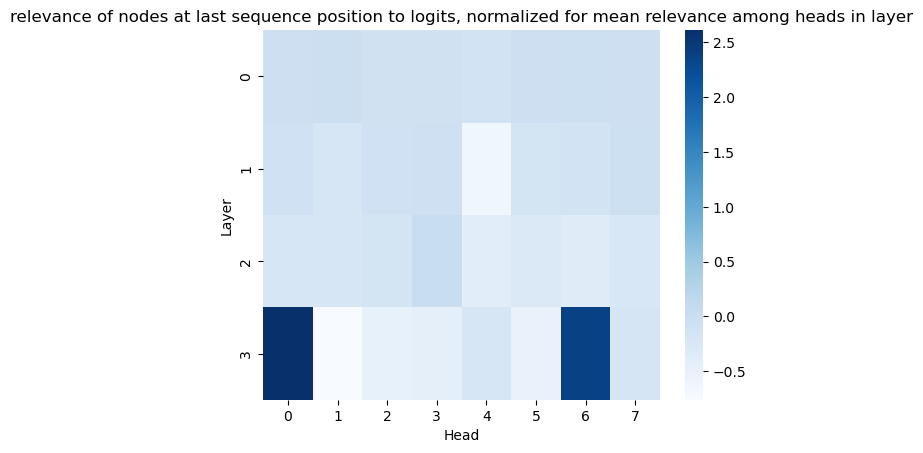

In [14]:

s = sns.heatmap(relevances[:, -1, :], xticklabels = range(num_attention_heads), yticklabels = range(num_layers), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("relevance of nodes at last sequence position to logits, normalized for mean relevance among heads in layer")
plt.show()

In [18]:
for result in results[:20]:
    print(result)

Result(ablation_set=(Node(layer_idx=3, sequence_idx=40, attn_head_idx=0),), score=3.5854855)
Result(ablation_set=(Node(layer_idx=3, sequence_idx=40, attn_head_idx=6),), score=1.620693)
Result(ablation_set=(Node(layer_idx=2, sequence_idx=40, attn_head_idx=3),), score=0.26229173)
Result(ablation_set=(Node(layer_idx=3, sequence_idx=40, attn_head_idx=7),), score=0.1636591)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=15, attn_head_idx=5),), score=0.11920023)
Result(ablation_set=(Node(layer_idx=2, sequence_idx=40, attn_head_idx=7),), score=0.09153849)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=15, attn_head_idx=0),), score=0.033045173)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=34, attn_head_idx=1),), score=0.02659972)
Result(ablation_set=(Node(layer_idx=2, sequence_idx=29, attn_head_idx=7),), score=0.025986627)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=27, attn_head_idx=1),), score=0.024690509)
Result(ablation_set=(Node(layer_idx=2, sequence_idx=18, attn_

In [ ]:
import itertools
import functools
encoding = model.tokenizer.encode_plus(prompts[prompt_idx].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask

# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
'''
ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
]
source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

'''
ablation_sets = []
for layer in range(num_layers):
    for attn_head in range(num_attention_heads):
        ablation_sets.append(tuple(Node(layer, seq_pos, attn_head) for seq_pos in range(seq_len)))

target_nodes = []

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets) #, num_at_time=32)

Running inputs 0 to 32 (of 32)


In [ ]:
text = prompts[prompt_idx].clean_prompt

relevances = np.zeros((num_layers, num_attention_heads))
tokens = model.to_str_tokens(text) # NOT to_tokens(text)
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []

for layer_idx in range(num_layers):
    for head_idx in range(num_attention_heads):
        score = 0
        decomp = out_decomps[layer_idx * num_attention_heads + head_idx]
        correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
        rel_correct_logit = decomp.rel[0, -1, correct_logit_idx]
        incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                         pos_labels.index("rand0"),
                         pos_labels.index("rand1"),
                         pos_labels.index("rand2"),
                         pos_labels.index("rand3"),
                         pos_labels.index("rand4"),
                         pos_labels.index("rand5"),
                         pos_labels.index("rand6"),
                         pos_labels.index("rand7"),
                         pos_labels.index("rand8"),
                         pos_labels.index("rand9"),
                         pos_labels.index("rand10"),
                         ]
        incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
        rel_incorrect_logits = decomp.rel[0, -1, incorrect_logit_idxs]
        score = np.min(rel_correct_logit - rel_incorrect_logits)
        relevances[layer_idx, head_idx] = score
        results.append(Result(decomp.ablation_set, score))
sums_per_layer = np.sum(relevances, axis=1)
sums_per_layer[sums_per_layer == 0] = -1e-8
normalized_relevances = relevances / np.expand_dims(sums_per_layer, 1)
results.sort(key=operator.attrgetter('score'), reverse=True)

In [ ]:
for result in results[:20]:
    print("%d.%d: " % (result.ablation_set[0].layer_idx, result.ablation_set[0].attn_head_idx), result.score)

3.0:  3.5854855
3.6:  1.620693
2.3:  0.2665378
3.7:  0.1636591
2.7:  0.11762053
0.0:  0.022501111
0.3:  0.015666306
2.0:  0.00905484
1.7:  0.0027136207
1.3:  0.0024920702
2.1:  -0.0019327998
1.2:  -0.0033437312
2.6:  -0.0044555664
0.5:  -0.0048312545
0.1:  -0.006903589
0.6:  -0.008307397
0.2:  -0.011153758
1.0:  -0.012790024
0.7:  -0.022209883
0.4:  -0.023172408


In [76]:
'''
Arg movers: 3.0, 3.6 at last position (40)
Induction: 1.4 at last position (40)
Prev token: 0.2 at B_doc, or the one after? (34) or (35) # can't be found by patching, maybe can be found here
Prev token: 2.0 at C_def (15)
Prev token: 1.4 at the fourth comma?? (14)

Also 0.5 at B_def (13), C_def (15) and B_doc (34), (0.4 relevant to 1.4), 1.2.
Also 2.3, 0.5, 1.2, 0.0, 0.1, 2.2, in roughly that order.
'''

'\nArg movers: 3.0, 3.6 at last position\nInduction: 1.4 at last position\nPrev token: 0.2 at B_doc, or the one after?\n'

## All in one cell

In [76]:
# Visualization of task
example_prompt = prompts[prompt_idx].clean_prompt
tokens = model.to_str_tokens(example_prompt)

example_answer = tokens[pos_labels.index("C_def")]
print(example_prompt)
print(example_answer)
transformer_lens.utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)


def parser(self, image, format, code, query, line, client):
    """leg shell nature

    :param code: mile protein
    :param query: process hat
    :param
 line
Tokenized prompt: ['<|BOS|>', '\n', 'def', ' parser', '(', 'self', ',', ' image', ',', ' format', ',', ' code', ',', ' query', ',', ' line', ',', ' client', '):', '\n   ', ' """', 'leg', ' shell', ' nature', '\n\n   ', ' :', 'param', ' code', ':', ' mile', ' protein', '\n   ', ' :', 'param', ' query', ':', ' process', ' hat', '\n   ', ' :', 'param']
Tokenized answer: [' line']


Performance on answer token:
Rank: 0        Logit: 21.15 Prob: 76.31% Token: | line|

Top 0th token. Logit: 21.15 Prob: 76.31% Token: | line|
Top 1th token. Logit: 17.00 Prob:  1.20% Token: | format|
Top 2th token. Logit: 16.60 Prob:  0.81% Token: | client|
Top 3th token. Logit: 16.38 Prob:  0.65% Token: | query|
Top 4th token. Logit: 16.27 Prob:  0.58% Token: | code|
Top 5th token. Logit: 16.24 Prob:  0.56% Token: | lines|
Top 6th token. Logit: 16.20 Prob:  0.54% Token: | int|
Top 7th token. Logit: 16.02 Prob:  0.45% Token: |:|
Top 8th token. Logit: 15.99 Prob:  0.44% Token: | source|
Top 9th token. Logit: 15.91 Prob:  0.40% Token: | data|


Ranks of the answer tokens: [(' line', 0)]

In [16]:
import itertools
import functools



model.reset_hooks(including_permanent=True)

NUM_SAMPLES = 8 # don't increase this past 1 if you don't know that patching the corrupted prompt values in works
NUM_OUTLIERS_TO_KEEP_PER_ITER = 2

corrupt_prompts = [prompt.corrupt_prompt['random_answer_doc'] for prompt in prompts[:NUM_SAMPLES]]

corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompts)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=1).squeeze(0) # now batch, layer, seq, n_heads, dim_attn (squeezed away the batch dim)
old_shape = corrupt_attention_outputs.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
corrupt_attention_outputs = corrupt_attention_outputs.view(new_shape) 

encoding_idxs = model.tokenizer.batch_encode_plus([prompt.clean_prompt for prompt in prompts], 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device).input_ids
# put in only one example for the attention mask, so that it has batch dimension 1, which broadcasts
attention_mask = model.tokenizer.encode_plus(prompts[0].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device).attention_mask
# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
# attention_mask = torch.tensor(np.hstack([np.ones((attention_mask.shape[0], 1), dtype=np.int64), encoding_idxs.cpu().numpy()]), device=device)
encoding_idxs = torch.tensor(np.hstack([np.ones((encoding_idxs.shape[0], 1), dtype=np.int64), encoding_idxs.cpu().numpy()]), device=device)

# encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = attention_mask.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

# Calculate relevance to logits
ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]
target_nodes = []

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_toy_model_4l(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)
# print(len(pre_layer_activations))
prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, \
                                                  device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, _ = batch_run(prop_fn, ablation_sets, num_at_time=(64 // NUM_SAMPLES))


/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


running input 0
running input 200
running input 400
running input 600
running input 800
running input 1000
running input 1200


In [17]:

results, relevances = compute_logits_decomposition_scores([prompt.clean_prompt for prompt in prompts[0:NUM_SAMPLES]], out_decomps)# text, out_decomps)
for result in results[:20]:
    print(result)

Result(ablation_set=(Node(layer_idx=3, sequence_idx=40, attn_head_idx=0),), score=2.1524660885334015)
Result(ablation_set=(Node(layer_idx=3, sequence_idx=40, attn_head_idx=6),), score=1.5224626958370209)
Result(ablation_set=(Node(layer_idx=2, sequence_idx=40, attn_head_idx=3),), score=0.10353106632828712)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=12, attn_head_idx=0),), score=0.0046040830202400684)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=12, attn_head_idx=7),), score=0.0038718872820027173)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=15, attn_head_idx=5),), score=0.003306705504655838)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=12, attn_head_idx=4),), score=0.0030077453702688217)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=12, attn_head_idx=3),), score=0.0016807264764793217)
Result(ablation_set=(Node(layer_idx=1, sequence_idx=21, attn_head_idx=4),), score=0.0008666748180985451)
Result(ablation_set=(Node(layer_idx=3, sequence_idx=0, attn_head

In [18]:
'''
corrupt_prompts = [prompt.corrupt_prompt['random_answer_doc'] for prompt in prompts[:NUM_SAMPLES]]

corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompts)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=1).squeeze(0) # now layer, seq, n_heads, dim_attn (squeezed away the batch dim)
old_shape = corrupt_attention_outputs.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
corrupt_attention_outputs = corrupt_attention_outputs.view(new_shape)
'''
target_nodes = [Node(3, 40, 0), Node(3, 40, 6)]
    
ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
    ]
source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]
prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, \
                                         device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
_, target_decomps = batch_run(prop_fn, ablation_sets, num_at_time=(64 // NUM_SAMPLES))


running input 0
running input 200
running input 400
running input 600
running input 800
running input 1000
running input 1200


In [21]:

results, relevances = calculate_target_decomposition_scores(target_decomps, normalized=True)

for result in results[:20]:
    print(result.ablation_set[0])

Node(layer_idx=1, sequence_idx=40, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=15, attn_head_idx=5)
Node(layer_idx=1, sequence_idx=33, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=27, attn_head_idx=5)
Node(layer_idx=0, sequence_idx=15, attn_head_idx=0)
Node(layer_idx=1, sequence_idx=16, attn_head_idx=0)
Node(layer_idx=0, sequence_idx=34, attn_head_idx=5)
Node(layer_idx=1, sequence_idx=16, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=15, attn_head_idx=1)
Node(layer_idx=2, sequence_idx=35, attn_head_idx=3)
Node(layer_idx=1, sequence_idx=27, attn_head_idx=2)
Node(layer_idx=1, sequence_idx=15, attn_head_idx=0)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=0)
Node(layer_idx=2, sequence_idx=34, attn_head_idx=2)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=1)
Node(layer_idx=0, sequence_idx=27, attn_head_idx=0)
Node(layer_idx=1, sequence_idx=28, attn_head_idx=4)
Node(layer_idx=1, sequence_idx=35, attn_head_idx=4)
Node(layer_idx=2, sequence_idx=27, attn_head_idx=2)
Node(layer_idx

In [13]:

# Now, find maximally relevant source nodes to target nodes

outliers_per_iter = []
while True:
    outliers = results[:NUM_OUTLIERS_TO_KEEP_PER_ITER]
    outliers_per_iter.append(outliers)
    target_nodes = [r.ablation_set[0] for r in outliers]
    print(target_nodes)
    should_break = True
    for node in target_nodes:
        if node.layer_idx != 0:
            should_break = False
    if should_break:
        break
    
    ranges = [
            [layer for layer in range(num_layers)],
            [sequence_position for sequence_position in range(seq_len)],
            # [ioi_dataset.word_idx['IO'][0]],
            [attention_head_idx for attention_head_idx in range(num_attention_heads)]
        ]
    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes]
    prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, \
                                             device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    _, target_decomps = batch_run(prop_fn, ablation_sets, num_at_time=(64 // NUM_SAMPLES))
    
    results, relevances = calculate_target_decomposition_scores(target_decomps)


/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


running input 0
running input 200
running input 400
running input 600
running input 800
running input 1000
running input 1200


NameError: name 'prompt_idx' is not defined

In [32]:
all_nodes = []
for it in outliers_per_iter:
    for result in it:
        if result.ablation_set[0] not in all_nodes:
            all_nodes.append(result.ablation_set[0])
for node in all_nodes:
    print((node))

Node(layer_idx=3, sequence_idx=40, attn_head_idx=0)
Node(layer_idx=3, sequence_idx=40, attn_head_idx=6)
Node(layer_idx=0, sequence_idx=15, attn_head_idx=5)
Node(layer_idx=0, sequence_idx=34, attn_head_idx=5)


## Circuit evaluation

In [35]:
print(corrupt_attention_outputs.shape)

torch.Size([4, 100, 41, 8, 64])


In [99]:
'''
def correctness_rate(model, prompts, patch_values=None):
    correct = 0
    for idx, prompt in enumerate(prompts):
        if patch_values is not None:
            model.reset_hooks(including_permanent=True)
            model = add_mean_ablation_hook(model, patch_values=patch_values[:, idx, :, :, :], circuit=circuit)
        tokens = model.to_str_tokens(prompt)
        print(tokens)
        # it's perhaps better to check if the model's prediction logit is highest by a certain threshold.
        correct_answer = tokens[pos_labels.index("C_def")]
        model_prediction = model.to_string(model.generate(prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1])
        if model_prediction == correct_answer:
            correct += 1
    return correct / len(prompts)
'''
def correctness_rate(logits, test_dataset):
    total = 0
    # text = test_dataset[i]
    tokens = model.to_str_tokens(test_dataset) # NOT to_tokens(text)
    correct_logits = np.array([model.to_single_token(tokens[i][pos_labels.index("C_def")]) for i in range(len(test_dataset))])
    # correct_logits = logits[list(range(len(test_dataset))), -1, correct_logit_idxs]
    predicted_logits = np.argmax(logits.cpu().numpy()[:, -1, :], axis=-1)
    return np.sum(correct_logits == predicted_logits)

In [24]:
def logits_to_ave_logit_diff(logits, test_dataset):
    total = 0
    for i in range(len(test_dataset)):
        text = test_dataset[i]
        tokens = model.to_str_tokens(text) # NOT to_tokens(text)
        correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
        rel_correct_logit = logits[i, -1, correct_logit_idx]
        incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                         pos_labels.index("rand0"),
                         pos_labels.index("rand1"),
                         pos_labels.index("rand2"),
                         pos_labels.index("rand3"),
                         pos_labels.index("rand4"),
                         pos_labels.index("rand5"),
                         pos_labels.index("rand6"),
                         pos_labels.index("rand7"),
                         pos_labels.index("rand8"),
                         pos_labels.index("rand9"),
                         pos_labels.index("rand10"),
                         ]
        incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
        rel_incorrect_logits = logits[0, -1, incorrect_logit_idxs]
        total += np.min(rel_correct_logit - rel_incorrect_logits)
    avg = total / len(test_dataset)
    return avg

In [97]:
model.reset_hooks(including_permanent=True)

batch_size = 200

docstring_ind_prompt_kwargs = dict(
    n_matching_args=3,
    n_def_prefix_args=2,
    n_def_suffix_args=1,
    n_doc_prefix_args=0,
    met_desc_len=3,
    arg_desc_len=2
)
prompts = [docstring_ind_prompt_gen("rest", **docstring_ind_prompt_kwargs) for _ in range(batch_size)]
# Get a "better" dataset, i.e, ones where the model answers the correct answer, preferably by a wide margin.
# the toy model actually isn't very good at the docstring task, only getting it right like 50-75% of the time.
# We obviously can't investigate the question of how the model does the docstring task if it's not actually "doing" it.
good_prompts = []
for prompt in prompts:
    clean_prompt = prompt.clean_prompt
    tokens = model.to_str_tokens(clean_prompt)
    # it's perhaps better to check if the model's prediction logit is highest by a certain threshold.
    correct_answer = tokens[pos_labels.index("C_def")]
    model_prediction = model.to_string(model.generate(clean_prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1])
    if model_prediction == correct_answer:
        good_prompts.append(prompt)
prompts = good_prompts
print(len(prompts))


TEST_DATASET_SIZE = 100
test_dataset = [prompt.clean_prompt for prompt in prompts[:TEST_DATASET_SIZE:]]

corrupt_prompts = [prompt.corrupt_prompt['random_answer_doc'] for prompt in prompts[:TEST_DATASET_SIZE]]

corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompts)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=0) # now batch, layer, seq_ nheads, dim_model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

118


In [100]:
model.reset_hooks(including_permanent=True)
logits, cache = model.run_with_cache(test_dataset) # full model performance
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))

3.661138000488281
100


In [98]:
circuit = [Node(layer_idx=3, sequence_idx=40, attn_head_idx=0),
          Node(layer_idx=3, sequence_idx=40, attn_head_idx=6),
           Node(layer_idx=1, sequence_idx=40, attn_head_idx=4),
        # Node(layer_idx=0, sequence_idx=15, attn_head_idx=5),
        # Node(layer_idx=1, sequence_idx=33, attn_head_idx=4),
        # Node(layer_idx=0, sequence_idx=27, attn_head_idx=5),
        # Node(layer_idx=0, sequence_idx=15, attn_head_idx=0),
        # Node(layer_idx=1, sequence_idx=16, attn_head_idx=0),
        Node(layer_idx=0, sequence_idx=34, attn_head_idx=5),
        # Node(layer_idx=1, sequence_idx=16, attn_head_idx=4),
        # Node(layer_idx=0, sequence_idx=15, attn_head_idx=1),
        # Node(layer_idx=2, sequence_idx=35, attn_head_idx=3),
        # Node(layer_idx=1, sequence_idx=27, attn_head_idx=2),
        # Node(layer_idx=1, sequence_idx=15, attn_head_idx=0),
        # Node(layer_idx=0, sequence_idx=1, attn_head_idx=0),
        # Node(layer_idx=2, sequence_idx=34, attn_head_idx=2),
        # Node(layer_idx=0, sequence_idx=1, attn_head_idx=1),
        # Node(layer_idx=0, sequence_idx=27, attn_head_idx=0),
        # Node(layer_idx=1, sequence_idx=28, attn_head_idx=4),
          ]
model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=circuit)
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))
# (3, 0), (3, 6), (1, 4), (0, 5), (0, 0), (1, 0), (1, 4), (0, 1), (2, 3), (1, 2)

1.8475144004821777
[ 2160  5575  7538 10207  1802  2063  3476  4090   931  7538  3637  3637
  1360  4466   931  6161  1802  2347  3407   845  3195  4759  2063  1361
  8464  4298  8464  4059  4059  3159  3585  1615   801  1615 14046  2374
  3407 19151   922  9433  6692  3469   898  3476  2160   745  5575 21435
  3808  1364  6627  3340  4522  9433  2796  2525  3469  3808   980  4360
  1242  5076  3485  1631  1631  6161  2181 19151  2176  2426   931  3514
  1294  2181  2520  4622  1242 21435  3064  2787 10644  5811  3797  2426
   745  2520  3656   980  2288  2127   845  1142 10207  1819  6161 21435
 10391  4522  6161  3808]
[ 1802  1615  7538  2306  1802  3407  4059  4090   931  7538  3637  3637
  1142  5224   931  6161  1390  4059    28   845  2374 13729  1802  2741
  1390  4298   539  4059  4059  3476  1242  5076  1364  1615  9433  2374
   898 19151   922  9433  6692  1294 10391  3476  1530   745  5575  1819
  3808  1195  6627  1390  7108  1390  3485  3808  3469  5127   980  2426
  1242

In [81]:
random_circuit = random.sample(source_nodes, 20)
model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=random_circuit) # baseline 
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))

-2.0950055742263793
[ 4145  2796  3476  1802  1218  3485  4522  1142  1218  1615  3485  2181
  7336  7123  2629  4522  2347   931  1921  4522  3637   922  3797  5076
  3808  2176 13729 14046 21435  1802  1052  3929  2662  2232  1382 10391
  2530  5811   922  5566  1668  2160  7538 10391  9433  2347  3929  2382
  1921  1056  1361  1360  4090   980  1359  3485  1631  3476  2525  3195
   980  3797 10644 10391  8464  5575  3064   980  4522  2426  3135  1802
  1056  1056   931   922  3929  2426  2306  2288  3808  5811  1819 21435
 10644  5811  5224  7538  1359  1360  2336  1921 21435  6627  1052  4686
  3797  2530  2063  1350]
[ 4686  5566  1056  6627  1390  1359  4622  1056   743  1819  3476  2629
  4522  4059  1294  1056  1390  7336  7108  4059  3407  3476  2232  4090
  1056  2426  2181  1359  4622  1242  4059  3135  1819  4622  4622  1819
  2306  1819 10207  2426  2165  6692  5575  2520  4466  6161  2176  2525
  2517  2525  2741  1819  2530  2165  2741  2374  4466   931  2787  1390
  710

## Not including sequence positions

In [88]:
circuit = []
for (layer_idx, head_idx) in [(3, 0), (3, 6), (1, 4), (0, 5), (0, 0), (1, 0), (1, 4), (0, 1), (2, 3), (1, 2)]: # this is our finding
    for seq_pos in range(seq_len):
        circuit.append(Node(layer_idx, seq_pos, head_idx))
        model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=circuit)
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
model.reset_hooks(including_permanent=True)

print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))

3.235892753601074
[ 4145  2796  3476  1802  1218  3485  4522  1142  1218  1615  3485  2181
  7336  7123  2629  4522  2347   931  1921  4522  3637   922  3797  5076
  3808  2176 13729 14046 21435  1802  1052  3929  2662  2232  1382 10391
  2530  5811   922  5566  1668  2160  7538 10391  9433  2347  3929  2382
  1921  1056  1361  1360  4090   980  1359  3485  1631  3476  2525  3195
   980  3797 10644 10391  8464  5575  3064   980  4522  2426  3135  1802
  1056  1056   931   922  3929  2426  2306  2288  3808  5811  1819 21435
 10644  5811  5224  7538  1359  1360  2336  1921 21435  6627  1052  4686
  3797  2530  2063  1350]
[ 4145  5566  3476  1802  1218  2520  4622  1218  1316  1615  4622 19151
  4522  7123  2629  2160  2347   931  1921  4522  2306   922  2629  5076
  4622  2063  3929  4522 10207  1802  1052  1819  2662  4622  1382 10391
  3808  1819   922  2426  1668  2160  5575  2426  4466   931  1819  2382
  1921  2741  6692  1360  4090  7123  1359  3485  1631  3476  5811  1390
   980 

In [91]:

# 0.0 and 2.2 are negative in impact
# docstring project result
circuit = []
for (layer_idx, head_idx) in [(0, 2), (0, 4), (0, 5), (1, 2), (1, 4), (2, 0), (3, 0), (3, 6)]: 
    for seq_pos in range(seq_len):
        circuit.append(Node(layer_idx, seq_pos, head_idx))
model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=circuit)
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))
model.reset_hooks(including_permanent=True)


# docstring project + 
circuit = []

for (layer_idx, head_idx) in [(0, 2), (0, 4), (0, 5), (1, 2), (1, 4), (2, 0), (3, 0), (3, 6), (1, 0)]:
    for seq_pos in range(seq_len):
        circuit.append(Node(layer_idx, seq_pos, head_idx))
model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=circuit)
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))
model.reset_hooks(including_permanent=True)

# docstring project ++ 
circuit = []

for (layer_idx, head_idx) in [(0, 2), (0, 4), (0, 5), (1, 2), (1, 4), (2, 0), (3, 0), (3, 6), (1, 0), (0, 1), (2, 3)]:
    for seq_pos in range(seq_len):
        circuit.append(Node(layer_idx, seq_pos, head_idx))
model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, patch_values=corrupt_attention_outputs, circuit=circuit)
logits, cache = model.run_with_cache(test_dataset) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
model.reset_hooks(including_permanent=True)
print(ave_logit_diff)
print(correctness_rate(logits, test_dataset))

2.884234743118286
[ 4145  2796  3476  1802  1218  3485  4522  1142  1218  1615  3485  2181
  7336  7123  2629  4522  2347   931  1921  4522  3637   922  3797  5076
  3808  2176 13729 14046 21435  1802  1052  3929  2662  2232  1382 10391
  2530  5811   922  5566  1668  2160  7538 10391  9433  2347  3929  2382
  1921  1056  1361  1360  4090   980  1359  3485  1631  3476  2525  3195
   980  3797 10644 10391  8464  5575  3064   980  4522  2426  3135  1802
  1056  1056   931   922  3929  2426  2306  2288  3808  5811  1819 21435
 10644  5811  5224  7538  1359  1360  2336  1921 21435  6627  1052  4686
  3797  2530  2063  1350]
[ 4145  5566  3476  1802  1390  3485  4622  1218   743  1615  3485 19151
  4522  3585  2629  2160  2530   931  1921  4522  2306   922  5575  5076
  4622  2063  3929  1242  4622  1802  1052  1819  1819  2232  1382 10391
  3808  2796   922   818  1668  1615  7538  2520  9433 14842  3929  2382
  1921  2525  6692  1819  4090  7123  1359  3485  1294   931  2525  1390
   980 

In [48]:
    
'''
Docstring post's analysis:
Arg movers: 3.0, 3.6 at last position (40)
Induction: 1.4 at last position (40)
Prev token: 0.2 at B_doc, or the one after? (34) or (35) # can't be found by patching, maybe can be found here
Prev token: 2.0 at C_def (15)
Prev token: 1.4 at the fourth comma?? (14)

Also 0.5 at B_def (13), C_def (15) and B_doc (34), (0.4 relevant to 1.4), 1.2.
Also 2.3, 0.5, 1.2, 0.0, 0.1, 2.2, in roughly that order.
'''

"\nArg movers: 3.0, 3.6 at last position (40)\nInduction: 1.4 at last position (40)\nPrev token: 0.2 at B_doc, or the one after? (34) or (35) # can't be found by patching, maybe can be found here\nPrev token: 2.0 at C_def (15)\nPrev token: 1.4 at the fourth comma?? (14)\n\nAlso 0.5 at B_def (13), C_def (15) and B_doc (34), (0.4 relevant to 1.4), 1.2.\nAlso 2.3, 0.5, 1.2, 0.0, 0.1, 2.2, in roughly that order.\n"